In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os

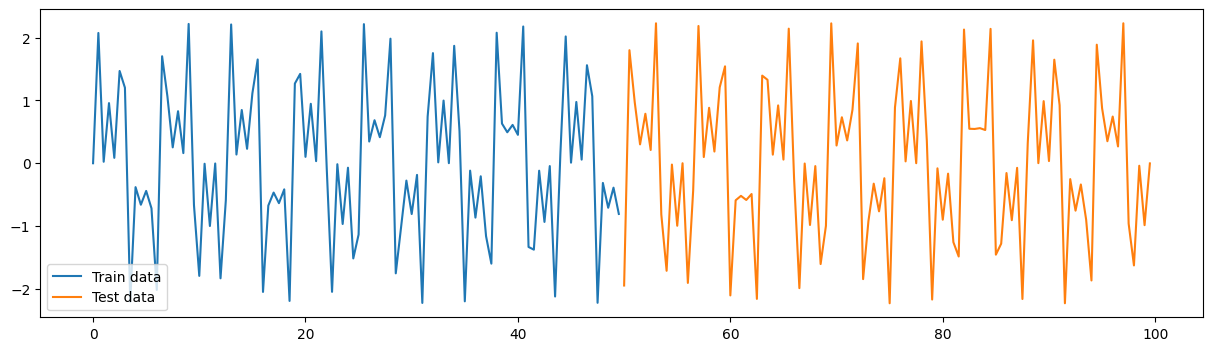

torch.Size([80, 20, 1]) torch.Size([80, 1]) torch.Size([80, 20, 1]) torch.Size([80, 1])
torch.Size([32, 20, 1]) torch.Size([32, 1])


In [7]:
def truth_func(x): 
    return np.sin(x) + np.sin(3*x) + np.sin(5*x)
    # return np.sin(x)

X_train = np.arange(0, 50, .5)
Y_train = truth_func(X_train)

X_test = np.arange(50, 100, .5)
Y_test = truth_func(X_test)

plt.figure(figsize=(15, 4))
plt.plot(X_train, Y_train, label="Train data")
plt.plot(X_test, Y_test, label="Test data")
plt.legend(loc="lower left")
plt.show()

def create_dataset(data, look_back:int=1): 
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return torch.tensor(X, dtype=torch.float32).view(-1, look_back, 1), torch.tensor(Y, dtype=torch.float32).view(-1, 1)

look_back = 20

trainX, trainY = create_dataset(Y_train, look_back)
testX, testY = create_dataset(Y_test, look_back)

train_loader = DataLoader(TensorDataset(trainX, trainY), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(testX, testY), batch_size=32, shuffle=True)

print(trainX.shape, trainY.shape, testX.shape, testY.shape)

for x, y in train_loader:
    print(x.shape, y.shape)
    break

# for i in range(trainX.shape[0]): 
#     plt.figure(figsize=(20, 4))
#     plt.plot(X_train, Y_train)
#     plt.plot(X_train[i:i+20], trainX[i].view(-1).numpy())
#     plt.plot(X_train[i+20], trainY[i].view(-1).numpy(), 'ro')
#     plt.show()
#     if i > 10: break 


In [3]:
trainX.shape

torch.Size([80, 20, 1])

In [4]:
class LSTMModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.fc = nn.Linear(100, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1])
        return x


In [5]:
a = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
b = nn.Linear(100, 1)

input = torch.randn(32, 10, 1)
output1, _ = a(input)
output2 = b(output1[:, -1])
output3 = b(output1)
print(output1.shape, output2.shape, output3.shape)



torch.Size([32, 10, 100]) torch.Size([32, 1]) torch.Size([32, 10, 1])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lstm = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)


(190, 190)

Epoch 1/200 - Train Loss: 0.0624 - Test Loss: 0.0592
Epoch 2/200 - Train Loss: 0.0559 - Test Loss: 0.0634
Epoch 3/200 - Train Loss: 0.0649 - Test Loss: 0.0894
Epoch 4/200 - Train Loss: 0.0786 - Test Loss: 0.0644
Epoch 5/200 - Train Loss: 0.0608 - Test Loss: 0.0482
Epoch 6/200 - Train Loss: 0.0714 - Test Loss: 0.1215
Epoch 7/200 - Train Loss: 0.1229 - Test Loss: 0.1691
Epoch 8/200 - Train Loss: 0.2237 - Test Loss: 0.1900
Epoch 9/200 - Train Loss: 0.2097 - Test Loss: 0.1249
Epoch 10/200 - Train Loss: 0.2204 - Test Loss: 0.1121
Epoch 11/200 - Train Loss: 0.1870 - Test Loss: 0.1974
Epoch 12/200 - Train Loss: 0.1230 - Test Loss: 0.2156
Epoch 13/200 - Train Loss: 0.1748 - Test Loss: 0.0755
Epoch 14/200 - Train Loss: 0.0886 - Test Loss: 0.0561
Epoch 15/200 - Train Loss: 0.0995 - Test Loss: 0.0826
Epoch 16/200 - Train Loss: 0.0605 - Test Loss: 0.0629
Epoch 17/200 - Train Loss: 0.0627 - Test Loss: 0.0608
Epoch 18/200 - Train Loss: 0.0711 - Test Loss: 0.0379
Epoch 19/200 - Train Loss: 0.0582 - T

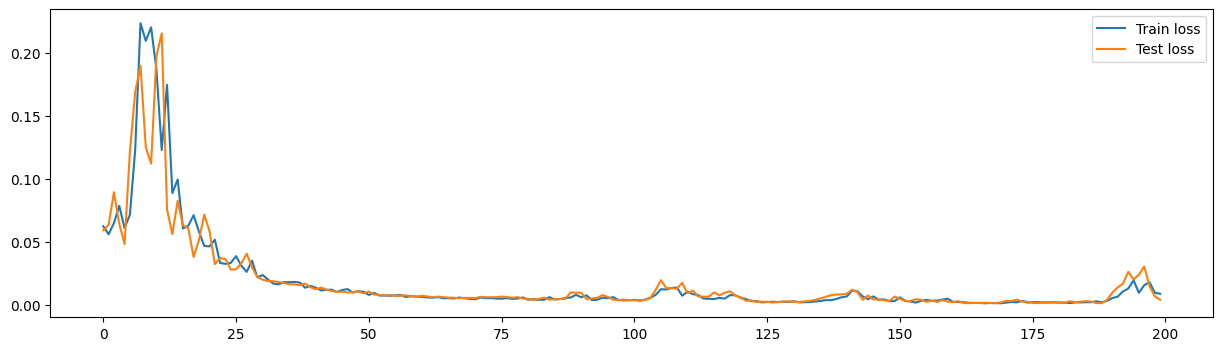

In [60]:
n_epochs = 200
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    lstm.train()
    running_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = lstm(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))

    lstm.eval()
    running_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = lstm(x)
            loss = criterion(output, y)
            running_loss += loss.item()
        test_loss.append(running_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss[-1]:.4f} - Test Loss: {test_loss[-1]:.4f}")

plt.figure(figsize=(15, 4))
plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.legend()
plt.show()

(80, 1)

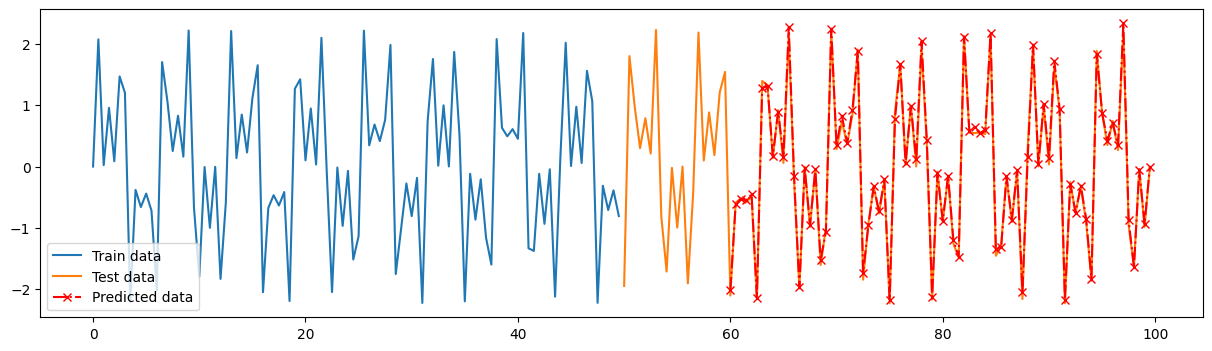

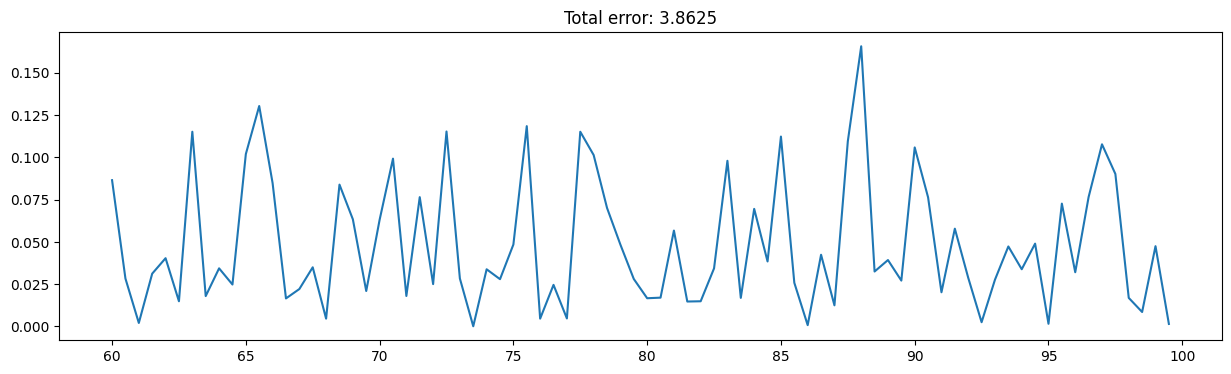

In [62]:
predY = lstm(testX.to(device)).cpu().detach().numpy()

plt.figure(figsize=(15, 4))
plt.plot(X_train, Y_train, label="Train data")
plt.plot(X_test, Y_test, label="Test data")
plt.plot(X_test[20:], predY, "r-.x", label="Predicted data")
plt.legend(loc="lower left")
plt.show()

plt.figure(figsize=(15, 4))
error = np.abs(Y_test[20:] - predY.flatten())
plt.plot(X_test[20:], error)
plt.title("Total error: %.4f" % np.sum(error))
plt.show()

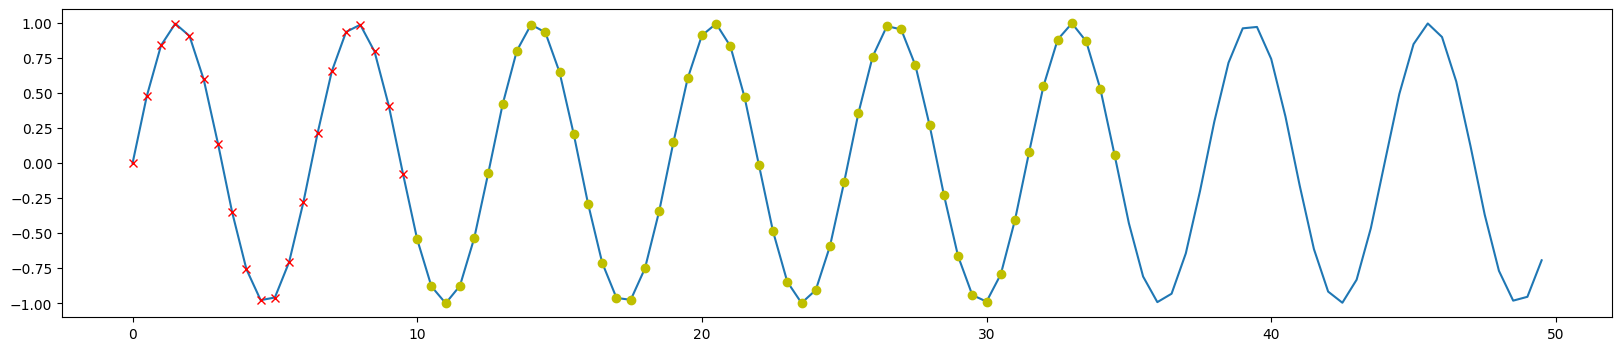

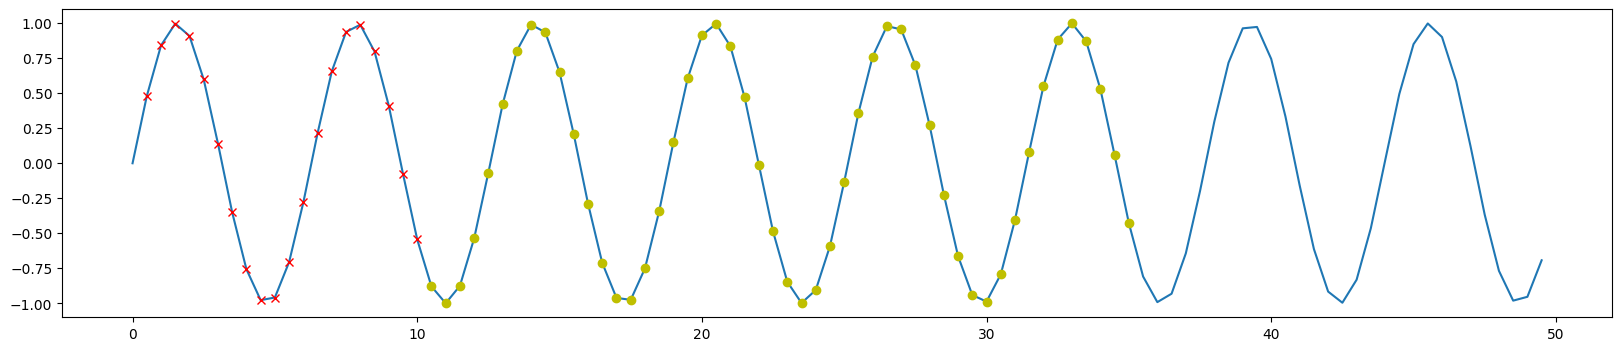

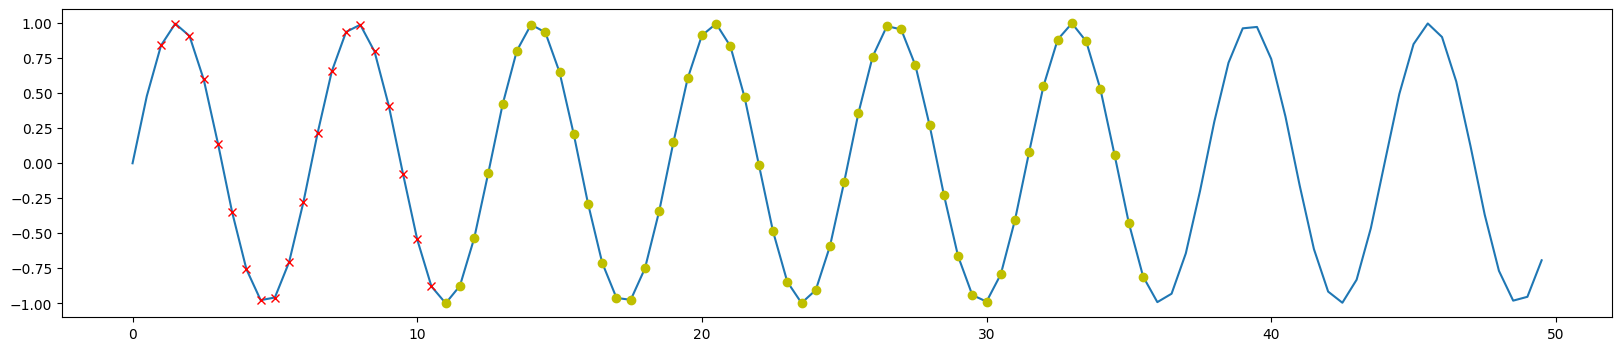

In [72]:
look_back = 20
look_forward = 50

class LSTMModelLong(nn.Module): 
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=2, batch_first=True)
        self.fc = nn.Linear(100, look_forward)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

lstm_long = LSTMModelLong().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_long.parameters(), lr=0.001)

def create_dataset_long(data, look_back:int=1, look_forward:int=1): 
    X, Y = [], []
    for i in range(len(data) - look_back - look_forward):
        X.append(data[i:(i + look_back)])
        Y.append(data[(i + look_back):(i + look_back + look_forward)])
    return torch.tensor(X, dtype=torch.float32).view(-1, look_back, 1), torch.tensor(Y, dtype=torch.float32).view(-1, look_forward)

trainX, trainY = create_dataset_long(Y_train, look_back, look_forward)
testX, testY = create_dataset_long(Y_test, look_back, look_forward)

train_loader = DataLoader(TensorDataset(trainX, trainY), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(testX, testY), batch_size=32, shuffle=True)

for i in range(3): 
    plt.figure(figsize=(20, 4))
    plt.plot(X_train, Y_train)
    plt.plot(X_train[i:i+look_back], trainX[i].view(-1).numpy(), "rx")
    plt.plot(X_train[i+look_back:i+look_forward+look_back], trainY[i].view(-1).numpy(), "yo")
    plt.show()

In [14]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

torch.Size([180, 10, 1]) torch.Size([180, 10]) torch.Size([180, 10, 1]) torch.Size([180, 10])


In [17]:
input = torch.randn(32, 10, 1)
a = nn.LSTM(input_size=1, hidden_size=100, num_layers=2, batch_first=True)
b = nn.Linear(100, look_forward)
output1, _ = a(input)
output2 = b(output1)
output3 = b(output1[:, -1])
print(input.shape, output1.shape, output2.shape, output3.shape)

torch.Size([32, 10, 1]) torch.Size([32, 10, 100]) torch.Size([32, 10, 10]) torch.Size([32, 10])


Epoch 1/200 - Train Loss: 0.5018 - Test Loss: 0.5005
Epoch 2/200 - Train Loss: 0.4999 - Test Loss: 0.4987
Epoch 3/200 - Train Loss: 0.4981 - Test Loss: 0.4969
Epoch 4/200 - Train Loss: 0.4963 - Test Loss: 0.4950
Epoch 5/200 - Train Loss: 0.4945 - Test Loss: 0.4932
Epoch 6/200 - Train Loss: 0.4927 - Test Loss: 0.4912
Epoch 7/200 - Train Loss: 0.4907 - Test Loss: 0.4890
Epoch 8/200 - Train Loss: 0.4885 - Test Loss: 0.4865
Epoch 9/200 - Train Loss: 0.4861 - Test Loss: 0.4838
Epoch 10/200 - Train Loss: 0.4834 - Test Loss: 0.4807
Epoch 11/200 - Train Loss: 0.4803 - Test Loss: 0.4772
Epoch 12/200 - Train Loss: 0.4768 - Test Loss: 0.4730
Epoch 13/200 - Train Loss: 0.4726 - Test Loss: 0.4680
Epoch 14/200 - Train Loss: 0.4675 - Test Loss: 0.4618
Epoch 15/200 - Train Loss: 0.4612 - Test Loss: 0.4542
Epoch 16/200 - Train Loss: 0.4534 - Test Loss: 0.4446
Epoch 17/200 - Train Loss: 0.4435 - Test Loss: 0.4325
Epoch 18/200 - Train Loss: 0.4311 - Test Loss: 0.4169
Epoch 19/200 - Train Loss: 0.4153 - T

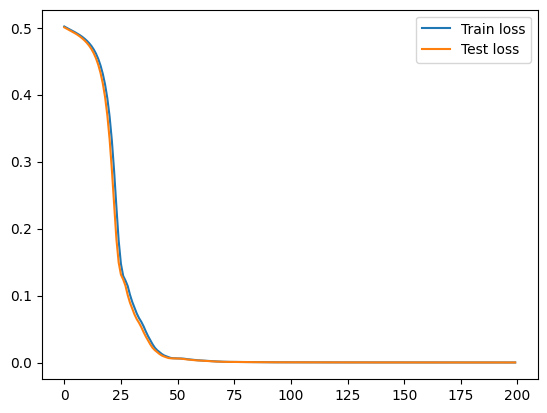

In [73]:
n_epochs = 200
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    lstm_long.train()
    running_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = lstm_long(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))

    lstm_long.eval()
    running_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = lstm_long(x)
            loss = criterion(output, y)
            running_loss += loss.item()
        test_loss.append(running_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss[-1]:.4f} - Test Loss: {test_loss[-1]:.4f}")

plt.plot(train_loss, label="Train loss")
plt.plot(test_loss, label="Test loss")
plt.legend()
plt.show()

In [74]:
y_x = Y_test[:look_back].copy()
y_x.shape
y_x = torch.tensor(y_x, dtype=torch.float32).view(-1, look_back, 1)
y_x.shape

torch.Size([1, 20, 1])

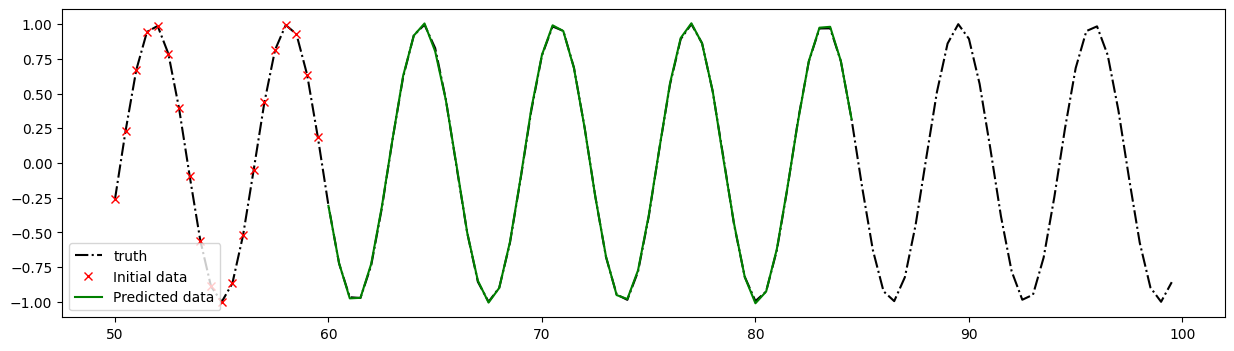

[]

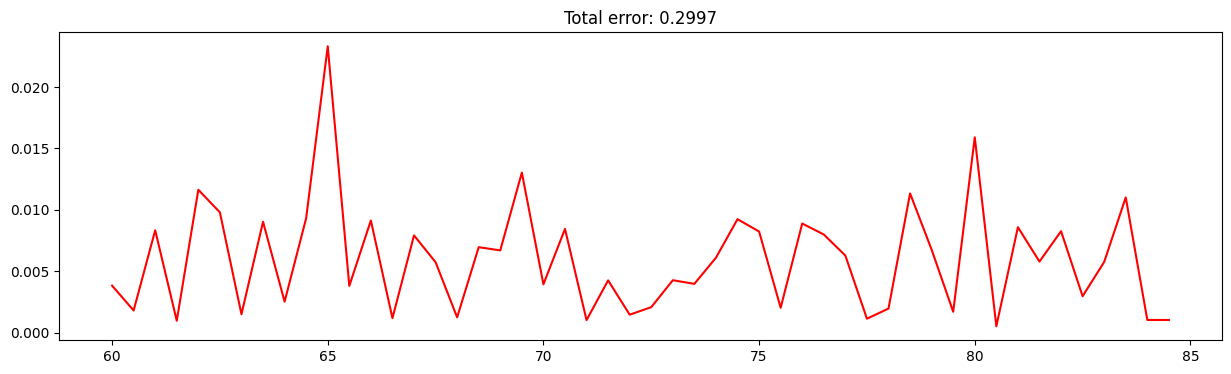

In [75]:
# predY = lstm_long(testX.to(device)).cpu().detach().numpy()
predY = lstm_long(y_x.to(device)).cpu().detach().numpy()


plt.figure(figsize=(15, 4))
# plt.plot(X_train, Y_train, label="Train data")
# plt.plot(X_test, Y_test, label="Test data")
# plt.plot(X_test[look_back:-look_forward], predY[:, 0], "g-", label="Predicted data")
plt.plot(X_test[:3*look_forward], Y_test[:3* look_forward], "k-.", label="truth")
plt.plot(X_test[:look_back], Y_test[:look_back], "rx", label="Initial data")
plt.plot(X_test[look_back:look_back+look_forward], predY[0].flatten(), "g-", label="Predicted data")
plt.legend(loc="lower left")
plt.show()

plt.figure(figsize=(15, 4))
error = np.abs(Y_test[look_back:look_back+look_forward] - predY[0].flatten())
plt.plot(X_test[look_back:look_back+look_forward], error, "r-", label="Error")
plt.title("Total error: %.4f" % np.sum(error))
plt.plot()

In [76]:
import platform
print(platform.platform())
print(platform.processor())
print(torch.__version__)


Windows-10-10.0.22631-SP0
Intel64 Family 6 Model 186 Stepping 2, GenuineIntel
2.3.1+cu121
